In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch 
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from typing import Callable
from tqdm import tqdm
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from dataclasses import dataclass
from CommonFunctions import *
%matplotlib inline

In [3]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.5
    weight_decay: float = 0.001
    epochs: int = 75
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dropout: float = 0.5
    batch_norm: bool = True
params = LearningParameters()

In [4]:
KERNEL_PARAMS = dict(kernel_size=5)
class CNN(nn.Module):
    def __init__(self, 
                 conv2_drop: float = 0, 
                 class2_drop: float = 0,
                 conv1_out: int = 2,
                 conv2_out: int = 4,
                 linear_out: int = 20):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=conv1_out, **KERNEL_PARAMS),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=conv1_out, out_channels=conv2_out, **KERNEL_PARAMS),
            *[nn.Dropout2d(p=conv2_drop)] if conv2_drop > 0 else [],
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        ) # image shape: (4x4)
        self.classifier_layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=conv2_out*4*4, out_features=linear_out),
            nn.ReLU()
        )
        self.classifier_layer2 = nn.Sequential(
            *[nn.Dropout(p=class2_drop)] if class2_drop > 0 else [],
            nn.Linear(in_features=linear_out, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier_layer2(self.classifier_layer1(self.conv_layer2(self.conv_layer1(x))))

In [5]:
data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
test_data = datasets.MNIST(
    root='./data', train=False, download=True, transform=data_transform, target_transform=None
)
data_classes = train_data.classes

In [6]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_function: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_function: Callable,
               device: torch.device = torch.device('cpu')) -> tuple[float:]: 
    train_loss: float = 0
    train_acc: float = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_function(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_function: nn.Module,
              accuracy_function: Callable,
              device: torch.device = torch.device('cpu')) -> tuple[float:]:
    test_loss: float = 0
    test_acc: float = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_function(test_pred, y).item()
            test_acc += accuracy_function(y, test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

def plot_loss_and_accuracy(title, epochs, train_loss_list, train_acc_list, test_loss_list, test_acc_list):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        axes[0].plot(range(1, epochs + 1), train_loss_list, 
                     label=f'Train: {train_loss_list[-1]:.2f}')
        axes[0].plot(range(1, epochs + 1), test_loss_list, 
                     label=f'Test: {test_loss_list[-1]:.2f}')
        axes[0].set(ylabel='Loss', title=title)
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        axes[1].plot(range(1, epochs + 1), train_acc_list, 
                     label=f'Train: {train_acc_list[-1]:.1f}%', zorder=3)
        axes[1].plot(range(1, epochs + 1), test_acc_list, 
                     label=f'Test: {test_acc_list[-1]:.1f}%', zorder=2)
        axes[1].plot([1, params.epochs], [99, 99], color='white', linestyle=':', 
                     label='99%', zorder=1)
        axes[1].set(xlabel='epoch', ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
        return figure, axes

In [7]:
loader_kwargs = dict(batch_size=params.batch_size, pin_memory=True, num_workers=params.cpu_count)
train_loader = DataLoader(train_data, **loader_kwargs, shuffle=True)
test_loader = DataLoader(test_data, **loader_kwargs, shuffle=False)
len(train_data), len(test_data), len(train_loader)

(60000, 10000, 469)

In [8]:
model1 = CNN(conv2_drop=params.dropout, class2_drop=params.dropout).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model1.parameters(), lr=params.learning_rate)
model1

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier_layer1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=20, bias=True)
    (2): ReLU()
  )
  (classifier_layer2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): LogSoftmax(dim=1)
  )
)

In [9]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model1, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model1, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 75/75 [17:03<00:00, 13.64s/it]


'Time: 1023.275 seconds'

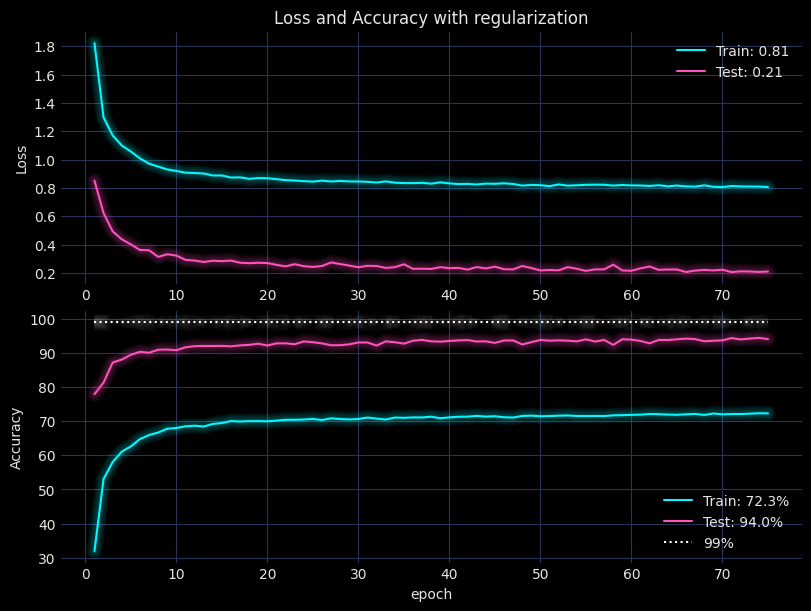

In [10]:
title = f'Loss and Accuracy with regularization'
plot_loss_and_accuracy(title, params.epochs, train_loss, train_acc, test_loss, test_acc);

## Turning off regularization

In [11]:
model2 = CNN().to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model2.parameters(), lr=params.learning_rate)
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model2, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model2, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 75/75 [16:31<00:00, 13.22s/it]


'Time: 991.629 seconds'

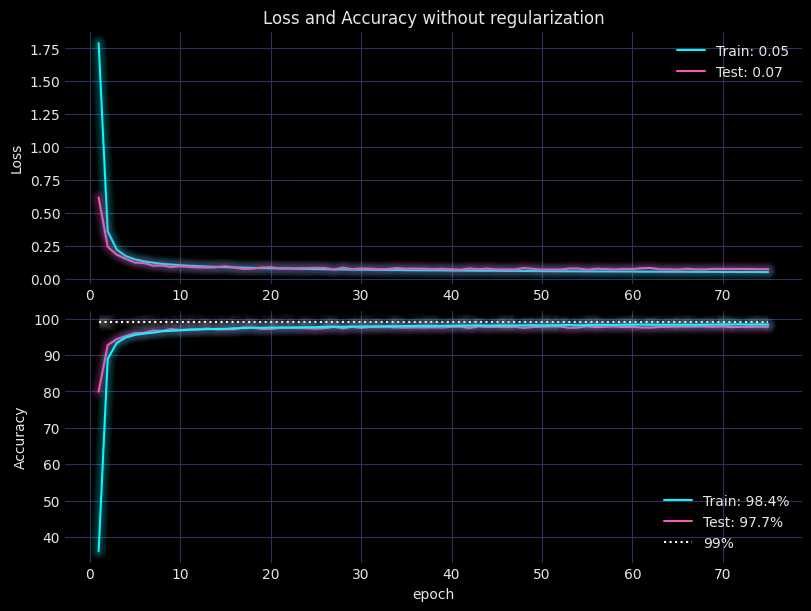

In [12]:
title = f'Loss and Accuracy without regularization'
plot_loss_and_accuracy(title, params.epochs, train_loss, train_acc, test_loss, test_acc);

The goal of regularization is to make the model generalized to predict unseen data, dropout is a popular regularization method that turns off random neurons leading to higher train loss in favor of validation loss.

## Tweaking for 99% accuracy

In [13]:
data_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomAffine(degrees=10,
                            translate=(0.1, 0.1),
                            scale=(1, 1.1),
                            shear=10),
    transforms.ToTensor()
])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
train_loader = DataLoader(train_data, **loader_kwargs, shuffle=True)

In [14]:
model3 = CNN(class2_drop=params.dropout, 
             conv2_drop=params.dropout,
             conv1_out=16,
             conv2_out=32,
             linear_out=48).to(params.device)
loss_fn = nn.NLLLoss(reduction='mean')
optimizer = torch.optim.SGD(
    model3.parameters(), lr=params.learning_rate, 
    momentum=params.momentum, weight_decay=params.weight_decay)
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model3, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model3, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 75/75 [18:00<00:00, 14.40s/it]


'Time: 1080.206 seconds'

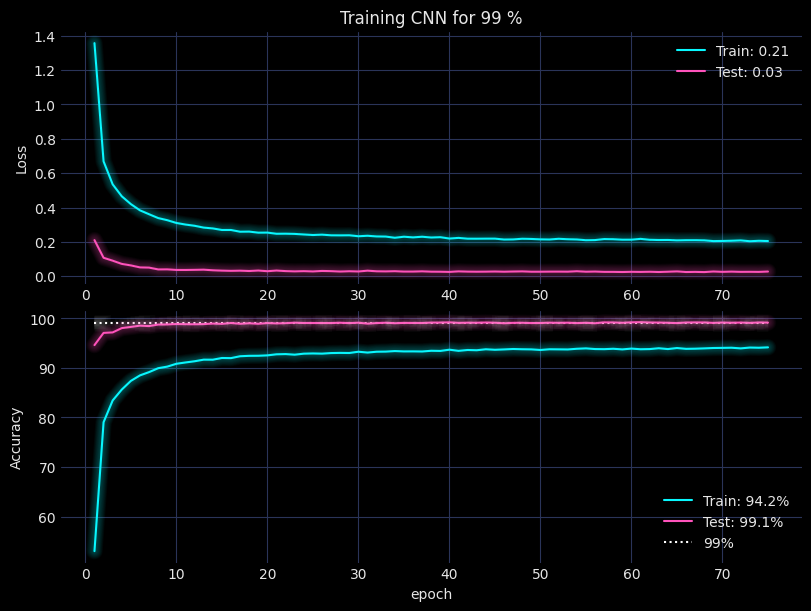

In [15]:
title = f'Training CNN for 99 %'
plot_loss_and_accuracy(title, params.epochs, train_loss, train_acc, test_loss, test_acc);

Increasing CNN capacity allows for 99% test accuracy.